# Experimentation and Uplift testing

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr, ttest_ind

In [7]:
# Load data
data = pd.read_csv("../data/raw/QVI_data.csv")

# Convert DATE to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Aggregate data to monthly level
data['Month'] = data['DATE'].dt.to_period('M')

# Calculate total sales, total customers, and average transactions per customer
monthly_data = data.groupby(['STORE_NBR', 'Month']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', 'nunique'),
    total_transactions=('TXN_ID', 'count')
).reset_index()

# Calculate average transactions per customer
monthly_data['avg_txn_per_cust'] = monthly_data['total_transactions'] / monthly_data['total_customers']

In [15]:
def calculate_similarity(trial_data, control_data):
    """
    Calculates similarity between two time series.

    Args:
        trial_data: A pandas Series containing the time series data for the trial store.
        control_data: A pandas Series containing the time series data for the control store.

    Returns:
        A tuple containing the Pearson correlation coefficient and the magnitude distance (normalized).
    """
    # Ensure equal length for correlation calculation
    min_length = min(len(trial_data), len(control_data))
    trial_data = trial_data.iloc[:min_length]
    control_data = control_data.iloc[:min_length]

    # Calculate Pearson correlation
    correlation = trial_data.corr(control_data)

    # Calculate magnitude distance (normalized)
    min_val = min(trial_data.min(), control_data.min())
    max_val = max(trial_data.max(), control_data.max())
    magnitude = abs(trial_data.values - control_data.values).mean() / (max_val - min_val)

    return correlation, magnitude

In [16]:
# Identify control stores for each trial store
control_stores = {}
trial_stores = [77, 86, 88]

for trial_store in trial_stores:
    trial_data = monthly_data[monthly_data['STORE_NBR'] == trial_store]['total_sales']
    similarities = []
    
    for control_store in monthly_data['STORE_NBR'].unique():
        if control_store == trial_store:
            continue
        
        control_data = monthly_data[monthly_data['STORE_NBR'] == control_store]['total_sales']
        correlation, magnitude = calculate_similarity(trial_data, control_data)
        similarities.append((control_store, correlation, magnitude))
    
    # Sort by correlation and magnitude
    similarities = sorted(similarities, key=lambda x: (-x[1], -x[2]))
    control_stores[trial_store] = similarities[0][0]  # Best match

In [17]:
# Trial period (e.g., Oct 2018 to Dec 2018)
trial_period = pd.period_range('2018-10', '2018-12', freq='M')

# Compare trial and control stores
results = []

for trial_store, control_store in control_stores.items():
    trial_data = monthly_data[
        (monthly_data['STORE_NBR'] == trial_store) & (monthly_data['Month'].isin(trial_period))
    ]
    control_data = monthly_data[
        (monthly_data['STORE_NBR'] == control_store) & (monthly_data['Month'].isin(trial_period))
    ]
    
    # T-test for total sales
    t_stat, p_value = ttest_ind(trial_data['total_sales'], control_data['total_sales'])
    
    # Summarize findings
    result = {
        'Trial Store': trial_store,
        'Control Store': control_store,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'Significant': p_value < 0.05
    }
    results.append(result)

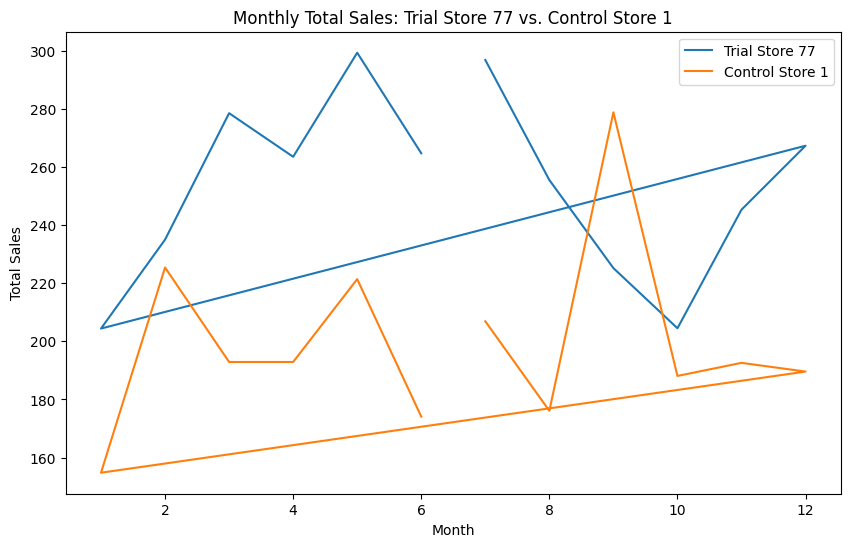

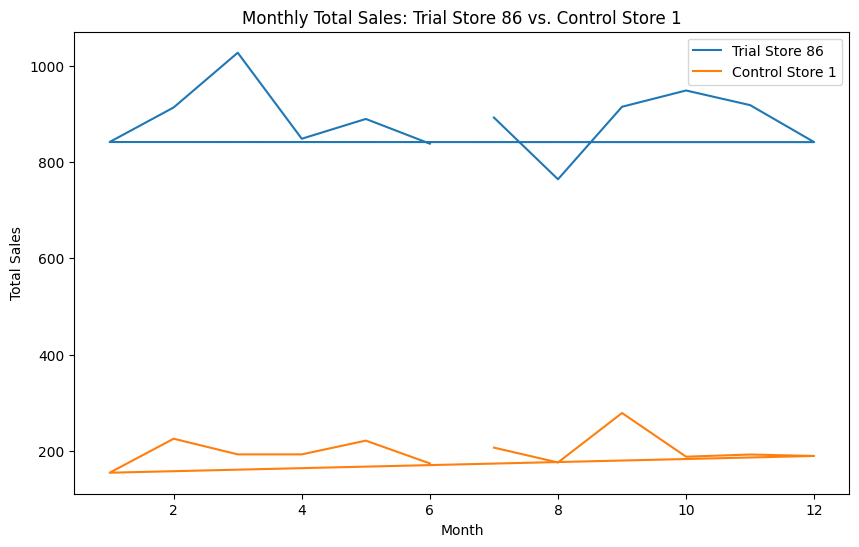

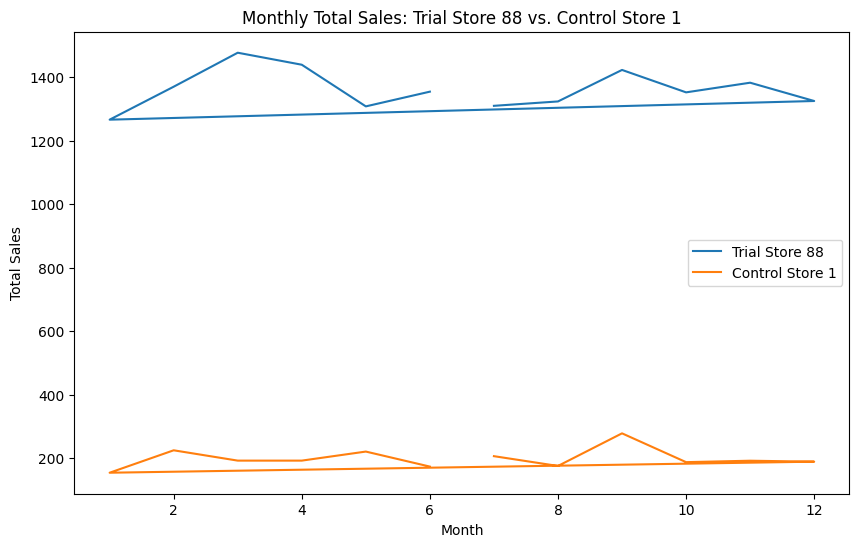

In [20]:
# Image folder for visualization reports
image_folder = '../reports/images/'
os.makedirs(image_folder, exist_ok=True)

# Example visualization for Trial Store 77
for trial_store in trial_stores:
    control_store = control_stores[trial_store]

    trial_data = monthly_data[monthly_data['STORE_NBR'] == trial_store]
    control_data = monthly_data[monthly_data['STORE_NBR'] == control_store]

    # Extract month values (numeric) from the Period objects
    trial_months = trial_data['Month'].dt.month  # Month as integer (1-12)
    control_months = control_data['Month'].dt.month

    plt.figure(figsize=(10, 6))
    plt.plot(trial_months, trial_data['total_sales'], label=f'Trial Store {trial_store}')
    plt.plot(control_months, control_data['total_sales'], label=f'Control Store {control_store}')
    plt.title(f'Monthly Total Sales: Trial Store {trial_store} vs. Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.savefig(f'{image_folder}Monthly Total Sales: Trial Store {trial_store} vs. Control Store {control_store}.png')
    plt.show()